In [1]:
from wrf import (getvar, interplevel, vertcross, 
                 CoordPair, ALL_TIMES, to_np,
                 get_cartopy, latlon_coords,
                 cartopy_xlim, cartopy_ylim, tk, pw, g_wind)
import wrf 
import glob
from netCDF4 import Dataset
import xarray as xr 
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np 
import cmaps
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import pickle

warnings.filterwarnings('ignore')

In [2]:
# #-- Read the Crounch/Lowman sounding station file. We need to convert the format of lat/lon (degree) into decimals; Remove some missing data
#-# And extract some basic variables (winds, pressure, humidity, temperature)


def process_obs_sounding(file_path, Gauge_site_Alt, IOP_date):
    """ This function will wash some missing data and extract the variables of interest"""
    with open(file_path, "r", encoding='WINDOWS-1252') as f:
        line_list = []
        for line in  f.readlines():
            line_list.append(line.split())

    line_list = line_list[2:] # skip the head line
    col_name  = ['Flight Time', 'UTC Time', 'Geo Height', 'Latitude', 'Longitude', 'Pressure', 'Temperature', 'Humidity', 'Wind Speed', 'Wind Direction', 'Slant Range', 'Elevation Angle']
    df       = pd.DataFrame(data=np.array(line_list),columns=col_name)

    ##--
    df.loc[(df['UTC Time'] =='//') | (df['Humidity'] =='//') | (df['Geo Height'] == Gauge_site_Alt) | (df['Pressure'] == '//') | (df['Temperature'] == '//')]  = np.nan
    df = df.dropna(axis=0)
    df_wash = df.reset_index(drop=True)

    ##--
    temp_sounding_time = df_wash['UTC Time'].values
    sounding_time = []
    for i in temp_sounding_time:
        temp = IOP_date + i  ## this parameter depends on individual case #!!!
        sounding_time.append(temp)
    sounding_time = pd.to_datetime(sounding_time)
    sounding_rh   = df_wash['Humidity'].values.astype(float) ## humidity
    sounding_tem  = df_wash['Temperature'].values.astype(float) ## temperature
    sounding_pr   = df_wash['Pressure'].values.astype(float) ## pressure
    sounding_ws   = df_wash['Wind Speed'].values.astype(float) ## wind speed
    sounding_wd   = df_wash['Wind Direction'].values.astype(float) ## wind direction
    sounding_ht   = df_wash['Geo Height'].values.astype(float)  ## altitude

    ##--
    lat_cr = df_wash['Latitude']
    symbol_1 = lat_cr.values[0][2]
    symbol_2 = lat_cr.values[0][5]
    symbol_3 = lat_cr.values[0][-1]

    lat_degree  = lat_cr.str.split(pat = symbol_1, expand = True).iloc[:,0].astype(float)
    temp1       = lat_cr.str.split(pat = symbol_1, expand = True).iloc[:,1]
    lat_minute  = temp1.str.split(pat = symbol_2, expand = True).iloc[:,0].astype(float)
    temp2       = temp1.str.split(pat = symbol_2, expand = True).iloc[:,1]
    lat_second  = temp2.str.split(pat = symbol_3, expand = True).iloc[:,0].astype(float)
    lat_cr_final = lat_degree + lat_minute/60. + lat_second/3600.
    sounding_lat = lat_cr_final.values

    ##--
    lon_cr = df_wash['Longitude']
    symbol_1 = lon_cr.values[0][4]
    symbol_2 = lon_cr.values[0][7]
    symbol_3 = lon_cr.values[0][-1]
    lon_degree  = lon_cr.str.split(pat = symbol_1, expand = True).iloc[:,0].astype(float)
    temp1       = lon_cr.str.split(pat = symbol_1, expand = True).iloc[:,1]
    lon_minute  = temp1.str.split(pat = symbol_2, expand = True).iloc[:,0].astype(float)
    temp2       = temp1.str.split(pat = symbol_2, expand = True).iloc[:,1]
    lon_second  = temp2.str.split(pat = symbol_3, expand = True).iloc[:,0].astype(float)
    lon_cr_final = lon_degree - lon_minute/60. - lon_second/3600.
    sounding_lon = lon_cr_final.values
    
    return sounding_time,sounding_rh, sounding_tem, sounding_pr, sounding_ws, sounding_wd, sounding_lat, sounding_lon, sounding_ht



In [3]:
# #-- In this step, we arange the data into different time windows
#-#

def temporal_process(time_window, sounding_time,sounding_rh, sounding_tem, sounding_pr, sounding_ws, sounding_wd, sounding_lat, sounding_lon, sounding_ht):
    
    timedelta = pd.Timedelta('00:02:30')
    s_time_list = []; e_time_list = []; 
    s_rh_list = []; s_tem_list = []; s_pr_list = []
    s_ws_list = []; s_wd_list  = []; s_lat_list = []
    s_lon_list = []; s_ht_list = []; ## extract sounding variables within each sub-period time window

    plot_s_rh_list = []; plot_s_tem_list = []; plot_s_pr_list = []
    plot_s_ws_list = []; plot_s_wd_list  = []; plot_s_lat_list = []
    plot_s_lon_list = []; plot_s_ht_list = [];

    for i in time_window:
        temp2  = pd.to_datetime(i)
        s_time = temp2 - timedelta
        e_time = temp2 + timedelta
        ind_x  = np.where((e_time >= sounding_time) & (sounding_time >= s_time))
        sel_rh  = sounding_rh[ind_x]; sel_tem = sounding_tem[ind_x]; sel_pr  = sounding_pr[ind_x]
        sel_ws  = sounding_ws[ind_x]; sel_wd  = sounding_wd[ind_x];  sel_lat = sounding_lat[ind_x]
        sel_lon = sounding_lon[ind_x]; sel_ht  = sounding_ht[ind_x]

        ##--
        s_time_list.append(s_time); e_time_list.append(e_time); 
        s_rh_list.append(sel_rh); s_tem_list.append(sel_tem); s_pr_list.append(sel_pr)
        s_ws_list.append(sel_ws); s_wd_list.append(sel_wd); s_lat_list.append(sel_lat);
        s_lon_list.append(sel_lon); s_ht_list.append(sel_ht)

        plot_s_rh_list.extend(sel_rh); plot_s_tem_list.extend(sel_tem); plot_s_pr_list.extend(sel_pr)
        plot_s_ws_list.extend(sel_ws); plot_s_wd_list.extend(sel_wd); plot_s_lat_list.extend(sel_lat);
        plot_s_lon_list.extend(sel_lon); plot_s_ht_list.extend(sel_ht)

    s_time_list = np.array(s_time_list); e_time_list = np.array(e_time_list); 
    s_rh_list   = np.array(s_rh_list); s_tem_list = np.array(s_tem_list)
    s_pr_list   = np.array(s_pr_list); s_ws_list  = np.array(s_ws_list)
    s_wd_list   = np.array(s_wd_list); s_lat_list = np.array(s_lat_list)
    s_lon_list  = np.array(s_lon_list); s_ht_list = np.array(s_ht_list)

    plot_s_rh_list   = np.array(plot_s_rh_list); plot_s_tem_list = np.array(plot_s_tem_list)
    plot_s_pr_list   = np.array(plot_s_pr_list); plot_s_ws_list  = np.array(plot_s_ws_list)
    plot_s_wd_list   = np.array(plot_s_wd_list); plot_s_lat_list = np.array(plot_s_lat_list)
    plot_s_lon_list  = np.array(plot_s_lon_list); plot_s_ht_list = np.array(plot_s_ht_list)
    return s_time_list,e_time_list,s_rh_list,s_pr_list,s_wd_list,s_lon_list,s_tem_list,s_ws_list,s_lat_list,s_ht_list,plot_s_rh_list,plot_s_pr_list,plot_s_wd_list,plot_s_lon_list,plot_s_tem_list,plot_s_ws_list,plot_s_lat_list,plot_s_ht_list



In [4]:
def extract_wrf_data(file_dir, IOPs_Gauge_site_wrf_period, IOPs, data, version):
    wrffile_list = []
    for i in range(IOPs_Gauge_site_wrf_period.shape[0]):
        file_path = file_dir +  'wrfout_d01_'+str(IOPs_Gauge_site_wrf_period[i]).replace(' ', '_')
        wrffile_list.append(file_path)

    wrffiles = []
    for f in wrffile_list: 
        wrffile = Dataset(f)
        wrffiles.append(wrffile)
    
    ##---------- extract variables
    rh_X_900m   = getvar(wrffiles, 'rh', timeidx=ALL_TIMES, method = "cat")  ## Extract the relative humidity
    tem_X_900m  = getvar(wrffiles, 'tc', timeidx=ALL_TIMES, method = "cat")  ## Extract the temperature (degC)
    pre_X_900m  = getvar(wrffiles, 'p',  timeidx=ALL_TIMES, method = "cat", units='hPa')  ## Extract the pressure (hPa)
    wspd_wdir_X_900m   = getvar(wrffiles, 'wspd_wdir',  timeidx=ALL_TIMES, method = "cat")  ## Extract the winds (m/s)
    wspd_X_900m = wspd_wdir_X_900m[0]  ## wind speed
    wdir_X_900m = wspd_wdir_X_900m[1]  ## wind direction
    ht_X_900m   = getvar(wrffiles, 'z',  timeidx=ALL_TIMES, method = "cat")  ## Extract the height
    wrf_lat_900m = getvar(wrffiles[0], 'XLAT')
    wrf_lon_900m = getvar(wrffiles[0], 'XLONG')
    
    ##------- save file
    np.save('/glade/scratch/zhixing/CTRL_Simulations/'+IOPs+'/For_Sounding_Valid/'+version+'rh_'+data+'_900m.npy', rh_X_900m)
    np.save('/glade/scratch/zhixing/CTRL_Simulations/'+IOPs+'/For_Sounding_Valid/'+version+'tem_'+data+'_900m.npy', tem_X_900m)
    np.save('/glade/scratch/zhixing/CTRL_Simulations/'+IOPs+'/For_Sounding_Valid/'+version+'pre_'+data+'_900m.npy', pre_X_900m)
    np.save('/glade/scratch/zhixing/CTRL_Simulations/'+IOPs+'/For_Sounding_Valid/'+version+'wspd_'+data+'_900m.npy', wspd_X_900m)
    np.save('/glade/scratch/zhixing/CTRL_Simulations/'+IOPs+'/For_Sounding_Valid/'+version+'wdir_'+data+'_900m.npy', wdir_X_900m)
    np.save('/glade/scratch/zhixing/CTRL_Simulations/'+IOPs+'/For_Sounding_Valid/'+version+'ht_'+data+'_900m.npy', ht_X_900m)
    

    
def load_data(IOPs, data, version):
    ##---------
    rh_X_900m = np.load('/glade/scratch/zhixing/CTRL_Simulations/'+IOPs+'/For_Sounding_Valid/'+version+'rh_'+data+'_900m.npy')
    tem_X_900m = np.load('/glade/scratch/zhixing/CTRL_Simulations/'+IOPs+'/For_Sounding_Valid/'+version+'tem_'+data+'_900m.npy')
    pre_X_900m = np.load('/glade/scratch/zhixing/CTRL_Simulations/'+IOPs+'/For_Sounding_Valid/'+version+'pre_'+data+'_900m.npy')
    wspd_X_900m = np.load('/glade/scratch/zhixing/CTRL_Simulations/'+IOPs+'/For_Sounding_Valid/'+version+'wspd_'+data+'_900m.npy')
    wdir_X_900m = np.load('/glade/scratch/zhixing/CTRL_Simulations/'+IOPs+'/For_Sounding_Valid/'+version+'wdir_'+data+'_900m.npy')
    ht_X_900m = np.load('/glade/scratch/zhixing/CTRL_Simulations/'+IOPs+'/For_Sounding_Valid/'+version+'ht_'+data+'_900m.npy')

    return rh_X_900m,tem_X_900m,pre_X_900m,wspd_X_900m,wdir_X_900m,ht_X_900m


## this function is used to get the "location" of the nearest point for the aircraft trajectory
def nearest_position(stn_lat_list, stn_lon_list, f_ht_list, xlat, xlon, wrf_ht):
    
    lat_ind_list = []; lon_ind_list = []; ht_ind_list = []
    
    for stn_lat, stn_lon, stn_ht in zip(stn_lat_list, stn_lon_list, f_ht_list):
        
        difflat = stn_lat - xlat; difflon = stn_lon - xlon;
        rad = np.multiply(difflat, difflat) + np.multiply(difflon, difflon) # difflat * difflat + difflon * difflon
        aa  = np.where(rad == np.min(rad)); ind = np.squeeze(np.array(aa))
        if ind.flatten().shape[0] == 2: ## make sure the nearest index is one pair
            lat_ind = ind[0]; lon_ind = ind[1] ## find the nearest point
        else:  ## sometimes the nearest index are two pairs
            lat_ind = ind[0][0]; lon_ind = ind[0][1]
                    
        col_wrf_ht = np.array(wrf_ht[:,lat_ind,lon_ind]) ## first we determine the location, then we select the column
        ht_diff    = np.array(abs(col_wrf_ht - stn_ht)) ## we subtract the flight height at that timestep, and the minimum differences represent the nearest point
        
        lat_ind_list.append(lat_ind); lon_ind_list.append(lon_ind); ht_ind_list.append(np.argmin(ht_diff))
        
    lat_ind_list = np.array(lat_ind_list); lon_ind_list = np.array(lon_ind_list); ht_ind_list = np.array(ht_ind_list)
    
    return lat_ind_list, lon_ind_list, ht_ind_list

In [5]:
def match_sounding_wrf_func(switch,rh_X_900m_list,ht_X_900m_list,tem_X_900m_list,pre_X_900m_list, wspd_X_900m_list,wdir_X_900m_list,\
                            time_window,s_rh_list,s_pr_list,s_wd_list,s_lon_list,s_tem_list,\
                            s_ws_list,s_lat_list,s_ht_list,wrf_lat_900m,wrf_lon_900m, reanalysis_list):

    # reanalysis_list = ['ERA5', 'ERAI', 'NARR', 'CFS2', 'ERA5_03CCN', 'ERA5_03CCN_MEYERS', 'ERA5_03CCN_YSU']

    rh_X_900m_sounding_all_dic = {}; tem_X_900m_sounding_all_dic = {}; ht_X_900m_sounding_all_dic = {};
    pre_X_900m_sounding_all_dic = {}; wspd_X_900m_sounding_all_dic = {}; wdir_X_900m_sounding_all_dic = {};

    for rh_X_900m, ht_X_900m, tem_X_900m, pre_X_900m, wspd_X_900m, wdir_X_900m,\
    keys in zip(rh_X_900m_list,ht_X_900m_list,tem_X_900m_list,pre_X_900m_list,wspd_X_900m_list,wdir_X_900m_list, reanalysis_list):

        rh_X_900m_sounding_all = []; tem_X_900m_sounding_all = []; pre_X_900m_sounding_all = []; 
        wspd_X_900m_sounding_all = []; wdir_X_900m_sounding_all = []; ht_X_900m_sounding_all = []

        for ii in range(time_window.shape[0]): ## each time window (temporal)
            ##--
            rh_x = s_rh_list[ii]; tem_x = s_tem_list[ii] ## sounding data during each time window
            pr_x = s_pr_list[ii]; ws_x  = s_ws_list[ii]
            wd_x = s_wd_list[ii]; ht_x  = s_ht_list[ii]
            lon_x = s_lon_list[ii]; lat_x = s_lat_list[ii]
            ##--
            ht_X_900m_x = ht_X_900m[ii] ## model snapshot at each time step
            rh_X_900m_x = rh_X_900m[ii]
            tem_X_900m_x = tem_X_900m[ii]
            pre_X_900m_x = pre_X_900m[ii]
            wspd_X_900m_x = wspd_X_900m[ii]
            wdir_X_900m_x = wdir_X_900m[ii]

            ## the index of latitude/longitude/height (spatial)
            lat_ind_list, lon_ind_list, ht_ind_list =\
            nearest_position(stn_lat_list=lat_x, stn_lon_list=lon_x,f_ht_list=ht_x,xlat=wrf_lat_900m, xlon=wrf_lon_900m, wrf_ht=ht_X_900m_x) ## we will extrat the nearest points in model relative to the sounding obs.
            ## now we get the index, we can find the right location in model

            rh_X_900m_sounding_x = [] ## X means different reanalysis datasets; x means different time windows; 
            tem_X_900m_sounding_x = []; pre_X_900m_sounding_x = []; 
            wspd_X_900m_sounding_x = []; wdir_X_900m_sounding_x = []; ht_X_900m_sounding_x = []

            for lat_ind, lon_ind, ht_ind in zip(lat_ind_list, lon_ind_list, ht_ind_list):

                rh_X_900m_sounding = []; tem_X_900m_sounding = []; pre_X_900m_sounding = []
                wspd_X_900m_sounding = []; wdir_X_900m_sounding = []; ht_X_900m_sounding = []

                ## the neighborhood approach (3*3*3)
                if switch & (ht_ind>=1): ## switch == 1, True; we used the neighboring approach to estimate the values for this grid point.
                    for i in range(-1,2):
                        for j in range(-1,2):
                            for k in range(-1,2):
                                ## 3*3*3 neighboring approach
                                ht_X_900m_sounding.append(ht_X_900m_x[ht_ind+i, lat_ind+j, lon_ind+k]);
                                rh_X_900m_sounding.append(rh_X_900m_x[ht_ind+i, lat_ind+j, lon_ind+k]);
                                tem_X_900m_sounding.append(tem_X_900m_x[ht_ind+i, lat_ind+j, lon_ind+k]);
                                pre_X_900m_sounding.append(pre_X_900m_x[ht_ind+i, lat_ind+j, lon_ind+k])
                                wspd_X_900m_sounding.append(wspd_X_900m_x[ht_ind+i, lat_ind+j, lon_ind+k])
                                wdir_X_900m_sounding.append(wdir_X_900m_x[ht_ind+i, lat_ind+j, lon_ind+k])

                    ## we used the neighborhood approach to calculate the mean values, indicating the value for the nearest point
                    avg_ht_X_900m_sounding = np.array(ht_X_900m_sounding).mean(); ht_X_900m_sounding_x.append(avg_ht_X_900m_sounding)
                    avg_rh_X_900m_sounding = np.array(rh_X_900m_sounding).mean(); rh_X_900m_sounding_x.append(avg_rh_X_900m_sounding)
                    avg_tem_X_900m_sounding = np.array(tem_X_900m_sounding).mean(); tem_X_900m_sounding_x.append(avg_tem_X_900m_sounding)
                    avg_pre_X_900m_sounding = np.array(pre_X_900m_sounding).mean(); pre_X_900m_sounding_x.append(avg_pre_X_900m_sounding)
                    avg_wspd_X_900m_sounding = np.array(wspd_X_900m_sounding).mean(); wspd_X_900m_sounding_x.append(avg_wspd_X_900m_sounding)
                    avg_wdir_X_900m_sounding = np.array(wdir_X_900m_sounding).mean(); wdir_X_900m_sounding_x.append(avg_wdir_X_900m_sounding)
                else:
                    ht_X_900m_sounding_x.append(ht_X_900m_x[ht_ind, lat_ind, lon_ind])
                    rh_X_900m_sounding_x.append(rh_X_900m_x[ht_ind, lat_ind, lon_ind])
                    tem_X_900m_sounding_x.append(tem_X_900m_x[ht_ind, lat_ind, lon_ind])
                    pre_X_900m_sounding_x.append(pre_X_900m_x[ht_ind, lat_ind, lon_ind])
                    wspd_X_900m_sounding_x.append(wspd_X_900m_x[ht_ind, lat_ind, lon_ind])
                    wdir_X_900m_sounding_x.append(wdir_X_900m_x[ht_ind, lat_ind, lon_ind])

            ht_X_900m_sounding_all.extend(ht_X_900m_sounding_x);
            rh_X_900m_sounding_all.extend(rh_X_900m_sounding_x); ## include all time windows
            tem_X_900m_sounding_all.extend(tem_X_900m_sounding_x);
            pre_X_900m_sounding_all.extend(pre_X_900m_sounding_x);
            wspd_X_900m_sounding_all.extend(wspd_X_900m_sounding_x);
            wdir_X_900m_sounding_all.extend(wdir_X_900m_sounding_x)
            # print(ht_ind_list, tem_X_900m_sounding)

        ht_X_900m_sounding_all_dic[keys] = np.array(ht_X_900m_sounding_all); rh_X_900m_sounding_all_dic[keys] = np.array(rh_X_900m_sounding_all)
        tem_X_900m_sounding_all_dic[keys] = np.array(tem_X_900m_sounding_all); pre_X_900m_sounding_all_dic[keys] = np.array(pre_X_900m_sounding_all)
        wspd_X_900m_sounding_all_dic[keys] = np.array(wspd_X_900m_sounding_all); wdir_X_900m_sounding_all_dic[keys] = np.array(wdir_X_900m_sounding_all)  

    return ht_X_900m_sounding_all_dic, rh_X_900m_sounding_all_dic, tem_X_900m_sounding_all_dic, pre_X_900m_sounding_all_dic, wspd_X_900m_sounding_all_dic, wdir_X_900m_sounding_all_dic

In [6]:
# #-- Visualize the sounding data and its matching model data
#-#

def visulization(title, plot_s_tem_list, plot_s_pr_list, plot_s_rh_list, plot_s_ws_list, plot_s_wd_list,\
                 plot_s_ht_list, ht_X_900m_sounding_all_dic,rh_X_900m_sounding_all_dic,tem_X_900m_sounding_all_dic,\
                 pre_X_900m_sounding_all_dic,wspd_X_900m_sounding_all_dic,wdir_X_900m_sounding_all_dic,\
                reanalysis_list, color_list):
##--
    fig, axs = plt.subplots(2,3,figsize=(16,12), sharey=True)

    ## plot the sounding data
    axs[0,0].plot(plot_s_tem_list,plot_s_ht_list, color='k')
    axs[0,1].plot(plot_s_pr_list,plot_s_ht_list, color='k')
    axs[0,2].plot(plot_s_rh_list,plot_s_ht_list, color='k')
    axs[1,0].plot(plot_s_ws_list,plot_s_ht_list, color='k')
    axs[1,1].plot(plot_s_wd_list,plot_s_ht_list, color='k')
    # axs[0,0].plot(plot_s_tem_list,plot_s_ht_list)


    ## plot the model data
    # reanalysis_list = ['ERA5', 'ERAI', 'NARR', 'CFS2', 'ERA5_03CCN', 'ERA5_03CCN_MEYERS', 'ERA5_03CCN_YSU']
    # color_list = ['#FFBF00','#FF7F50','#DE3163','#9FE2BF', '#40E0D0', '#6495ED', '#CCCCFF']
    lines_list = []
    for keys, color in zip(reanalysis_list, color_list):

        plot_wrf_ht_list, sel_ind  = np.unique(ht_X_900m_sounding_all_dic[keys], return_index=True)  
        ## Because sounding data points are way more dense (especially in upper air, since model eta level is gradually getting sparse as altitude increses);
        ## Thus, there are multiple repeated data points in model coordinate. We need to select the unique data points (exclude redundant information) to make the plot smooth
        plot_wrf_rh_list  = rh_X_900m_sounding_all_dic[keys][sel_ind]
        plot_wrf_tem_list = tem_X_900m_sounding_all_dic[keys][sel_ind]
        plot_wrf_pre_list = pre_X_900m_sounding_all_dic[keys][sel_ind]
        plot_wrf_wspd_list = wspd_X_900m_sounding_all_dic[keys][sel_ind]
        plot_wrf_wdir_list = wdir_X_900m_sounding_all_dic[keys][sel_ind]

        axs[0,0].plot(plot_wrf_tem_list,plot_wrf_ht_list, label = keys, color = color)
        axs[0,1].plot(plot_wrf_pre_list,plot_wrf_ht_list, label = keys, color = color)
        axs[0,2].plot(plot_wrf_rh_list,plot_wrf_ht_list,  label = keys, color = color)
        axs[1,0].plot(plot_wrf_wspd_list,plot_wrf_ht_list, label = keys, color = color)
        axs[1,1].plot(plot_wrf_wdir_list,plot_wrf_ht_list, label = keys, color = color)
        lines = Line2D([0], [0], label=keys,  color=color)
        lines_list.append(lines)


    ##-- tick parameters, labels
    x_label_list = ['Temperature ($^\circ$C)', 'Pressure (hPa)', 'Relative Humidity (%)', 'Wind Speed (m/s)', 'Wind Direction (\N{degree sign})']
    for ax, x_label in zip(np.array(axs).flatten(), x_label_list):
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax.tick_params(length=8, width=2, labelsize='x-large')
        ax.tick_params(which='minor',length=4, width=1, labelsize='x-large')
        ax.set_ylim(1000,8000)
        ax.set_yticklabels(['1','2','3','4','5','6','7','8'], fontsize='x-large')
        ax.set_xlabel(x_label, fontsize='x-large', fontweight='bold')

    axs[0,0].set_ylabel("Altitude (km)", fontsize='x-large', labelpad=10)
    axs[1,0].set_ylabel("Altitude (km)", fontsize='x-large', labelpad=10)


    ## A trick to manually plot the legend    
    axs[1,-1].spines['left'].set_color(None) 
    axs[1,-1].spines['right'].set_color(None)
    axs[1,-1].spines['top'].set_color(None)
    axs[1,-1].spines['bottom'].set_color(None)
    axs[1,-1].tick_params(which='minor',labelsize=0,length=0,width=0)
    axs[1,-1].tick_params(which='major',labelsize=0,length=0,width=0)
    
    axs[1,-1].legend(handles=lines_list, loc='center',fontsize='xx-large',edgecolor='k')

    ## add title for the figure
    fig.suptitle(t=title,y=0.92, fontsize = 'xx-large', fontweight='bold')

In [7]:
%%time
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------

def integration_func(IOPS_Gauge_site_file_path, IOPS_date, Gauge_site_Alt, IOPS_time_window, SWITCH1, SWITCH2, IOPS, VERSIONS, TITLE, reanalysis_list, color_list):
    """ combine pre-defined functions together, and encapsulating all together"""
    #!!!
    sounding_time, sounding_rh, sounding_tem, sounding_pr, sounding_ws, sounding_wd, sounding_lat, sounding_lon, sounding_ht =\
    process_obs_sounding(file_path=IOPS_Gauge_site_file_path, Gauge_site_Alt=Gauge_site_Alt, IOP_date=IOPS_date)
    
    # #************************
    # ##-- process the sounding data, group them by the time window
    # #!!!  
    s_time_list,e_time_list,s_rh_list,s_pr_list,s_wd_list,s_lon_list,s_tem_list,s_ws_list,s_lat_list,s_ht_list,plot_s_rh_list,\
    plot_s_pr_list,plot_s_wd_list,plot_s_lon_list,plot_s_tem_list,plot_s_ws_list,plot_s_lat_list,plot_s_ht_list=\
    temporal_process(time_window = IOPS_time_window, sounding_time=sounding_time,sounding_rh=sounding_rh,\
                     sounding_tem=sounding_tem, sounding_pr=sounding_pr, sounding_ws=sounding_ws, sounding_wd=sounding_wd,\
                     sounding_lat=sounding_lat, sounding_lon=sounding_lon, sounding_ht=sounding_ht)
    # #************************


    # #************************
    # #************************
    wrffile = Dataset('/glade/scratch/zhixing/CTRL_Simulations/IOP19/ERA5_900m/wrfout_d01_2017-03-04_14:00:00')
    wrf_lat_900m = getvar(wrffile, 'XLAT')  ## Extract the latitude (900-m resolution); The domain is fixed for all the different driving datasets
    wrf_lon_900m = getvar(wrffile, 'XLONG')  ## Extract the longitude (900-m resolution)

    #-- save IOPX 900m ERA5/ERAI/NARR/CFS2 (you only need to run this one time, and not necessary to use "get_var" to extract wrf data every time (Save your program execution time)
    ht_X_900m_IOPS_list = [];  rh_X_900m_IOPS_list = [];   pre_X_900m_IOPS_list = [];
    tem_X_900m_IOPS_list = []; wspd_X_900m_IOPS_list = []; wdir_X_900m_IOPS_list = [];
    
    for DATA in reanalysis_list:
        if SWITCH1:
            DATA_file_dir = '/glade/scratch/zhixing/CTRL_Simulations/'+IOPS+'/'+DATA+'_900m/' #!!!
            extract_wrf_data(file_dir=DATA_file_dir, IOPs_Gauge_site_wrf_period = IOPS_time_window, IOPs=IOPS,data=DATA, version=VERSIONS)



        ##------ load WRF IOPS 900m ERA5/ERAI/NARR/CFS2
        rh_DATA_900m_IOPS,tem_DATA_900m_IOPS,pre_DATA_900m_IOPS,wspd_DATA_900m_IOPS,wdir_DATA_900m_IOPS,ht_DATA_900m_IOPS = load_data(IOPs=IOPS, data=DATA, version=VERSIONS)
        ht_X_900m_IOPS_list.append(ht_DATA_900m_IOPS); rh_X_900m_IOPS_list.append(rh_DATA_900m_IOPS); tem_X_900m_IOPS_list.append(tem_DATA_900m_IOPS);
        pre_X_900m_IOPS_list.append(pre_DATA_900m_IOPS); wspd_X_900m_IOPS_list.append(wspd_DATA_900m_IOPS); wdir_X_900m_IOPS_list.append(wdir_DATA_900m_IOPS);
            
    # #************************
    # #************************
    ##------ find the sounding data location in WRF coordinate
    ## switch = 1, this parameter will decide whether we use the neighborhood approach
    ## the list of relative humidity from different driving datasets


    ht_X_900m_sounding_all_dic, rh_X_900m_sounding_all_dic, tem_X_900m_sounding_all_dic,\
    pre_X_900m_sounding_all_dic, wspd_X_900m_sounding_all_dic, wdir_X_900m_sounding_all_dic=\
    match_sounding_wrf_func(switch=SWITCH2,rh_X_900m_list=rh_X_900m_IOPS_list,ht_X_900m_list=\
                            ht_X_900m_IOPS_list,tem_X_900m_list=tem_X_900m_IOPS_list,pre_X_900m_list=\
                            pre_X_900m_IOPS_list,wspd_X_900m_list=wspd_X_900m_IOPS_list,wdir_X_900m_list=\
                            wdir_X_900m_IOPS_list,time_window=IOPS_time_window,s_rh_list=s_rh_list,s_pr_list=\
                            s_pr_list,s_wd_list=s_wd_list,s_lon_list=s_lon_list,s_tem_list=s_tem_list,s_ws_list=\
                            s_ws_list,s_lat_list=s_lat_list,s_ht_list=s_ht_list,wrf_lat_900m=wrf_lat_900m,\
                            wrf_lon_900m=wrf_lon_900m,reanalysis_list=reanalysis_list)


    visulization(title=TITLE, plot_s_tem_list=plot_s_tem_list, plot_s_pr_list=plot_s_pr_list, plot_s_rh_list=plot_s_rh_list,\
                 plot_s_ws_list=plot_s_ws_list, plot_s_wd_list=plot_s_wd_list, plot_s_ht_list=plot_s_ht_list,\
                 ht_X_900m_sounding_all_dic=ht_X_900m_sounding_all_dic,rh_X_900m_sounding_all_dic=rh_X_900m_sounding_all_dic,\
                 tem_X_900m_sounding_all_dic=tem_X_900m_sounding_all_dic,pre_X_900m_sounding_all_dic=pre_X_900m_sounding_all_dic,\
                 wspd_X_900m_sounding_all_dic=wspd_X_900m_sounding_all_dic,wdir_X_900m_sounding_all_dic=wdir_X_900m_sounding_all_dic,\
                 reanalysis_list=reanalysis_list,color_list=color_list)
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------

    return ht_X_900m_sounding_all_dic, rh_X_900m_sounding_all_dic, tem_X_900m_sounding_all_dic, pre_X_900m_sounding_all_dic, wspd_X_900m_sounding_all_dic, wdir_X_900m_sounding_all_dic,\
plot_s_tem_list, plot_s_pr_list, plot_s_rh_list, plot_s_ws_list, plot_s_wd_list, plot_s_ht_list

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.25 µs


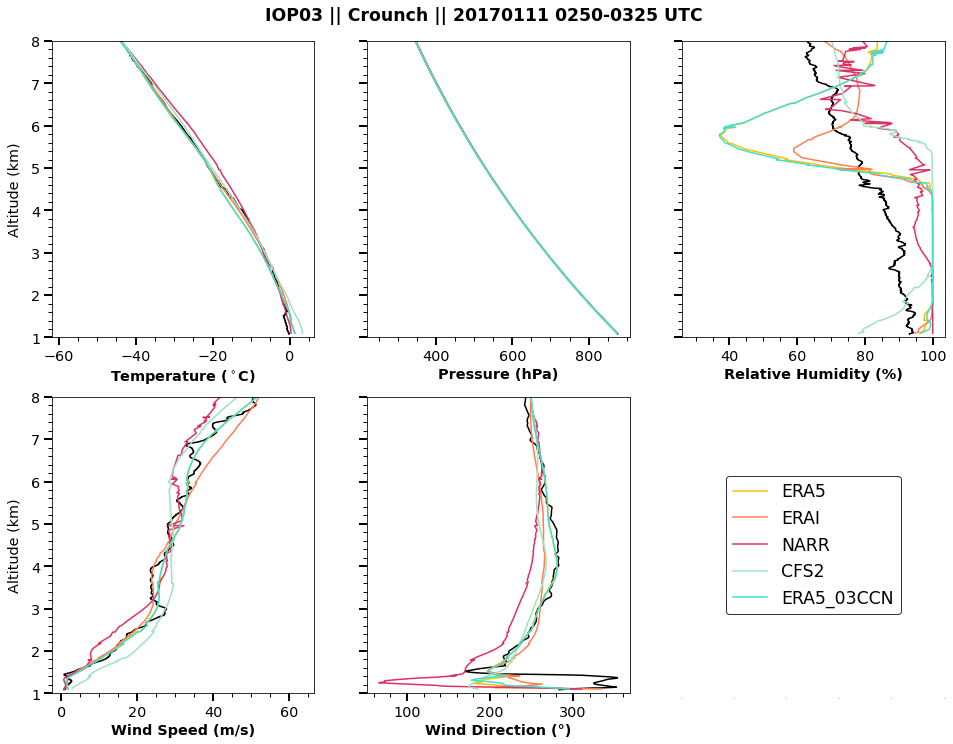

In [21]:
#************************
##-- Read Crounch sounding data during IOP03 period1
#!!!
IOPS_crounch_file_path = "/glade/work/zhixing/Analysis_DATA/SNOWIE_observation/RADIOSONDE/Crounch_sounding/kcrh201701110301.txt"
IOPS_date  = '20170111 '
Crounch_Alt = '1082.6' ## The altitude of sounding site
IOPS_time_window = pd.date_range('20170111 025000', '20170111 032500', freq='5min') ## this time window depends on individual case  #!!!
SWITCH1 = 0 ## whether extract wrf data from wrfoutput file and then save into numpy array file 
SWITCH2 = 1 ## whether use the neighborhood approach
IOPS = 'IOP03'
VERSIONS = 'v1_cr_'
TITLE = 'IOP03 || Crounch || 20170111 0250-0325 UTC'

REANALYSIS_LIST = ['ERA5', 'ERAI', 'NARR', 'CFS2', 'ERA5_03CCN'] # 'ERA5_03CCN_MEYERS', 'ERA5_03CCN_YSU', 'ERA5_03CCN_SEEDED']
COLOR_LIST = ['#FFBF00','#FF7F50','#DE3163','#9FE2BF', '#40E0D0'] #, '#6495ED', '#CCCCFF','purple']

# ht_X_900m_sounding_all_dic, rh_X_900m_sounding_all_dic, tem_X_900m_sounding_all_dic,\
# pre_X_900m_sounding_all_dic, wspd_X_900m_sounding_all_dic, wdir_X_900m_sounding_all_dic,\
# plot_s_tem_list, plot_s_pr_list, plot_s_rh_list, plot_s_ws_list, plot_s_wd_list, plot_s_ht_list \
# = integration_func(IOPS_Gauge_site_file_path=IOPS_crounch_file_path, IOPS_date=IOPS_date, Gauge_site_Alt=Crounch_Alt,\
#                    IOPS_time_window=IOPS_time_window, SWITCH1=SWITCH1, SWITCH2=SWITCH2, IOPS=IOPS, VERSIONS=VERSIONS,\
#                    TITLE=TITLE, reanalysis_list = REANALYSIS_LIST, color_list = COLOR_LIST)


plot_s_tem_list = np.load('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p1_cr_obs_s_tem_list.npy')
plot_s_pr_list  = np.load('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p1_cr_obs_s_pr_list.npy')
plot_s_rh_list  = np.load('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p1_cr_obs_s_rh_list.npy')
plot_s_ws_list  = np.load('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p1_cr_obs_s_ws_list.npy')
plot_s_wd_list  = np.load('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p1_cr_obs_s_wd_list.npy')
plot_s_ht_list  = np.load('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p1_cr_obs_s_ht_list.npy')


with open('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p1_cr_ht_X_900m_sounding_all_dic.pkl', 'rb') as f:
    ht_X_900m_sounding_all_dic = pickle.load(f)
    
with open('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p1_cr_rh_X_900m_sounding_all_dic.pkl', 'rb') as f:
    rh_X_900m_sounding_all_dic = pickle.load(f)
    
with open('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p1_cr_tem_X_900m_sounding_all_dic.pkl', 'rb') as f:
    tem_X_900m_sounding_all_dic = pickle.load(f)
    
with open('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p1_cr_pre_X_900m_sounding_all_dic.pkl', 'rb') as f:
    pre_X_900m_sounding_all_dic = pickle.load(f)
    
with open('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p1_cr_wspd_X_900m_sounding_all_dic.pkl', 'rb') as f:
    wspd_X_900m_sounding_all_dic = pickle.load(f)
    
with open('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p1_cr_wdir_X_900m_sounding_all_dic.pkl', 'rb') as f:
    wdir_X_900m_sounding_all_dic = pickle.load(f)
    
visulization(title=TITLE, plot_s_tem_list=plot_s_tem_list, plot_s_pr_list=plot_s_pr_list, plot_s_rh_list=plot_s_rh_list,\
             plot_s_ws_list=plot_s_ws_list, plot_s_wd_list=plot_s_wd_list, plot_s_ht_list=plot_s_ht_list,\
             ht_X_900m_sounding_all_dic=ht_X_900m_sounding_all_dic,rh_X_900m_sounding_all_dic=rh_X_900m_sounding_all_dic,\
             tem_X_900m_sounding_all_dic=tem_X_900m_sounding_all_dic,pre_X_900m_sounding_all_dic=pre_X_900m_sounding_all_dic,\
             wspd_X_900m_sounding_all_dic=wspd_X_900m_sounding_all_dic,wdir_X_900m_sounding_all_dic=wdir_X_900m_sounding_all_dic,\
            reanalysis_list = REANALYSIS_LIST, color_list = COLOR_LIST)

In [22]:
# ## So, this dictionary data contains the in-situ-wrf mathcing data in 4D (spatially and temporally) and used the neighboring approach

# with open('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p1_cr_ht_X_900m_sounding_all_dic.pkl', 'wb') as f:
#     pickle.dump(ht_X_900m_sounding_all_dic, f)
    
# with open('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p1_cr_rh_X_900m_sounding_all_dic.pkl', 'wb') as f:
#     pickle.dump(rh_X_900m_sounding_all_dic, f)
    
# with open('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p1_cr_tem_X_900m_sounding_all_dic.pkl', 'wb') as f:
#     pickle.dump(tem_X_900m_sounding_all_dic, f)
    
# with open('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p1_cr_pre_X_900m_sounding_all_dic.pkl', 'wb') as f:
#     pickle.dump(pre_X_900m_sounding_all_dic, f)

# with open('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p1_cr_wspd_X_900m_sounding_all_dic.pkl', 'wb') as f:
#     pickle.dump(wspd_X_900m_sounding_all_dic, f)

# with open('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p1_cr_wdir_X_900m_sounding_all_dic.pkl', 'wb') as f:
#     pickle.dump(wdir_X_900m_sounding_all_dic, f)

# np.save('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p1_cr_obs_s_tem_list.npy',plot_s_tem_list)
# np.save('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p1_cr_obs_s_pr_list.npy',plot_s_pr_list)
# np.save('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p1_cr_obs_s_rh_list.npy',plot_s_rh_list)
# np.save('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p1_cr_obs_s_ws_list.npy',plot_s_ws_list)
# np.save('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p1_cr_obs_s_wd_list.npy',plot_s_wd_list)
# np.save('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p1_cr_obs_s_ht_list.npy',plot_s_ht_list)


CPU times: user 6min 33s, sys: 1min 56s, total: 8min 29s
Wall time: 11min 24s


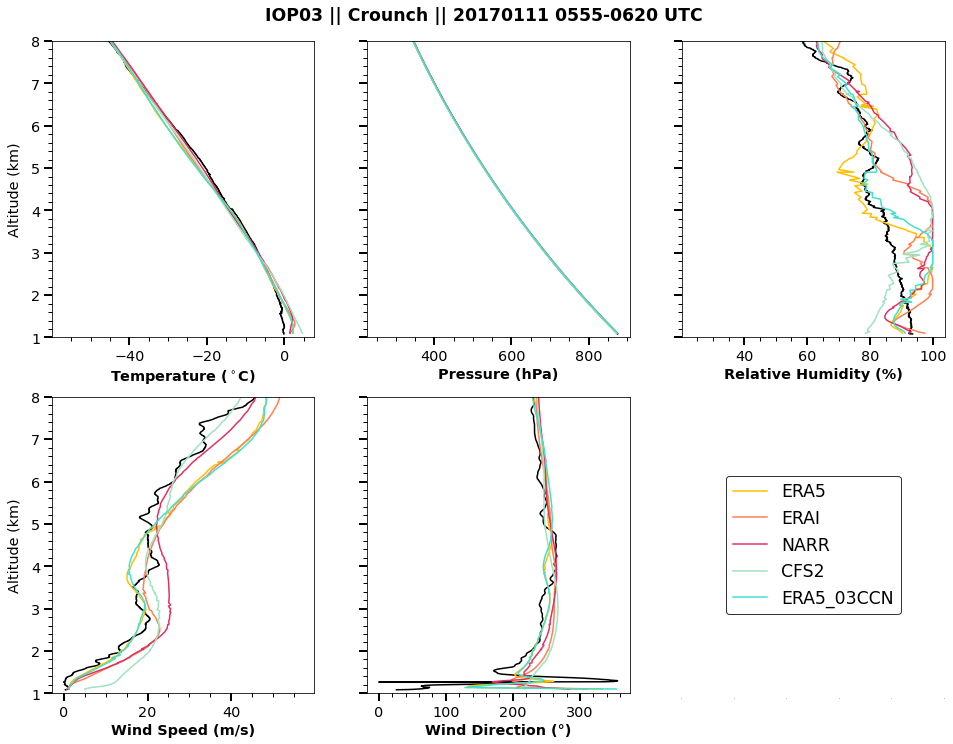

In [18]:
%%time
#************************
##-- Read Crounch sounding data during IOP03
#!!!

IOPS_crounch_file_path = "/glade/work/zhixing/Analysis_DATA/SNOWIE_observation/RADIOSONDE/Crounch_sounding/kcrh201701110601.txt"
IOPS_date  = '20170111 '
Crounch_Alt = '1082.6' ## The altitude of sounding site
IOPS_time_window = pd.date_range('20170111 055500', '20170111 062000', freq='5min') ## this time window depends on individual case  #!!!
SWITCH1 = 0 ## whether extract wrf data from wrfoutput file and then save into numpy array file 
SWITCH2 = 1 ## whether use the neighborhood approach
IOPS = 'IOP03'
VERSIONS = 'v2_cr_'
TITLE = 'IOP03 || Crounch || 20170111 0555-0620 UTC'

# REANALYSIS_LIST =['ERA5_03CCN_SEEDED']
# COLOR_LIST = ['purple']
REANALYSIS_LIST = ['ERA5', 'ERAI', 'NARR', 'CFS2', 'ERA5_03CCN'] # 'ERA5_03CCN_MEYERS', 'ERA5_03CCN_YSU', 'ERA5_03CCN_SEEDED']
COLOR_LIST = ['#FFBF00','#FF7F50','#DE3163','#9FE2BF', '#40E0D0'] #, '#6495ED', '#CCCCFF','purple']

# ht_X_900m_sounding_all_dic, rh_X_900m_sounding_all_dic, tem_X_900m_sounding_all_dic,\
# pre_X_900m_sounding_all_dic, wspd_X_900m_sounding_all_dic, wdir_X_900m_sounding_all_dic,\
# plot_s_tem_list, plot_s_pr_list, plot_s_rh_list, plot_s_ws_list, plot_s_wd_list, plot_s_ht_list \
# = integration_func(IOPS_Gauge_site_file_path=IOPS_crounch_file_path, IOPS_date=IOPS_date, Gauge_site_Alt=Crounch_Alt,\
#                    IOPS_time_window=IOPS_time_window, SWITCH1=SWITCH1, SWITCH2=SWITCH2, IOPS=IOPS, VERSIONS=VERSIONS,\
#                    TITLE=TITLE, reanalysis_list = REANALYSIS_LIST, color_list = COLOR_LIST)


plot_s_tem_list = np.load('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p2_cr_obs_s_tem_list.npy')
plot_s_pr_list  = np.load('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p2_cr_obs_s_pr_list.npy')
plot_s_rh_list  = np.load('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p2_cr_obs_s_rh_list.npy')
plot_s_ws_list  = np.load('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p2_cr_obs_s_ws_list.npy')
plot_s_wd_list  = np.load('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p2_cr_obs_s_wd_list.npy')
plot_s_ht_list  = np.load('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p2_cr_obs_s_ht_list.npy')


with open('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p2_cr_ht_X_900m_sounding_all_dic.pkl', 'rb') as f:
    ht_X_900m_sounding_all_dic = pickle.load(f)
    
with open('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p2_cr_rh_X_900m_sounding_all_dic.pkl', 'rb') as f:
    rh_X_900m_sounding_all_dic = pickle.load(f)
    
with open('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p2_cr_tem_X_900m_sounding_all_dic.pkl', 'rb') as f:
    tem_X_900m_sounding_all_dic = pickle.load(f)
    
with open('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p2_cr_pre_X_900m_sounding_all_dic.pkl', 'rb') as f:
    pre_X_900m_sounding_all_dic = pickle.load(f)
    
with open('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p2_cr_wspd_X_900m_sounding_all_dic.pkl', 'rb') as f:
    wspd_X_900m_sounding_all_dic = pickle.load(f)
    
with open('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p2_cr_wdir_X_900m_sounding_all_dic.pkl', 'rb') as f:
    wdir_X_900m_sounding_all_dic = pickle.load(f)
    
visulization(title=TITLE, plot_s_tem_list=plot_s_tem_list, plot_s_pr_list=plot_s_pr_list, plot_s_rh_list=plot_s_rh_list,\
             plot_s_ws_list=plot_s_ws_list, plot_s_wd_list=plot_s_wd_list, plot_s_ht_list=plot_s_ht_list,\
             ht_X_900m_sounding_all_dic=ht_X_900m_sounding_all_dic,rh_X_900m_sounding_all_dic=rh_X_900m_sounding_all_dic,\
             tem_X_900m_sounding_all_dic=tem_X_900m_sounding_all_dic,pre_X_900m_sounding_all_dic=pre_X_900m_sounding_all_dic,\
             wspd_X_900m_sounding_all_dic=wspd_X_900m_sounding_all_dic,wdir_X_900m_sounding_all_dic=wdir_X_900m_sounding_all_dic,\
            reanalysis_list = REANALYSIS_LIST, color_list = COLOR_LIST)

In [19]:
# ## So, this dictionary data contains the in-situ-wrf mathcing data in 4D (spatially and temporally) and used the neighboring approach

# with open('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p2_cr_ht_X_900m_sounding_all_dic.pkl', 'wb') as f:
#     pickle.dump(ht_X_900m_sounding_all_dic, f)
    
# with open('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p2_cr_rh_X_900m_sounding_all_dic.pkl', 'wb') as f:
#     pickle.dump(rh_X_900m_sounding_all_dic, f)
    
# with open('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p2_cr_tem_X_900m_sounding_all_dic.pkl', 'wb') as f:
#     pickle.dump(tem_X_900m_sounding_all_dic, f)
    
# with open('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p2_cr_pre_X_900m_sounding_all_dic.pkl', 'wb') as f:
#     pickle.dump(pre_X_900m_sounding_all_dic, f)

# with open('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p2_cr_wspd_X_900m_sounding_all_dic.pkl', 'wb') as f:
#     pickle.dump(wspd_X_900m_sounding_all_dic, f)

# with open('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p2_cr_wdir_X_900m_sounding_all_dic.pkl', 'wb') as f:
#     pickle.dump(wdir_X_900m_sounding_all_dic, f)

# np.save('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p2_cr_obs_s_tem_list.npy',plot_s_tem_list)
# np.save('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p2_cr_obs_s_pr_list.npy',plot_s_pr_list)
# np.save('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p2_cr_obs_s_rh_list.npy',plot_s_rh_list)
# np.save('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p2_cr_obs_s_ws_list.npy',plot_s_ws_list)
# np.save('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p2_cr_obs_s_wd_list.npy',plot_s_wd_list)
# np.save('/glade/scratch/zhixing/CTRL_Simulations/IOP03/For_Sounding_Valid/For_Plot_Processed_Data/p2_cr_obs_s_ht_list.npy',plot_s_ht_list)


CPU times: user 266 ms, sys: 2.83 ms, total: 269 ms
Wall time: 387 ms


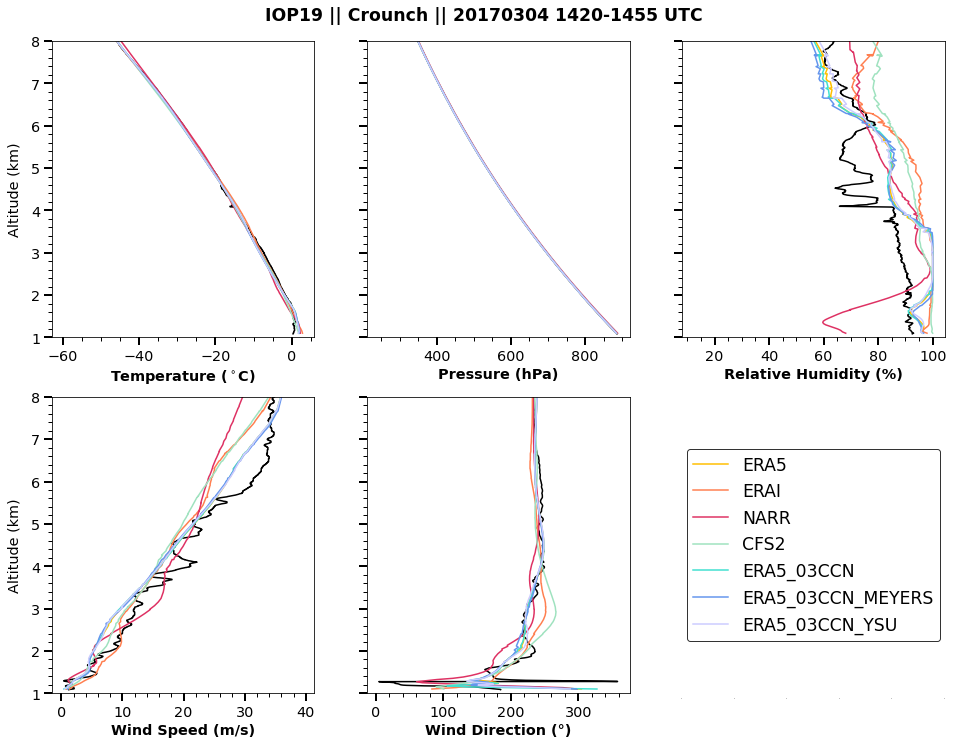

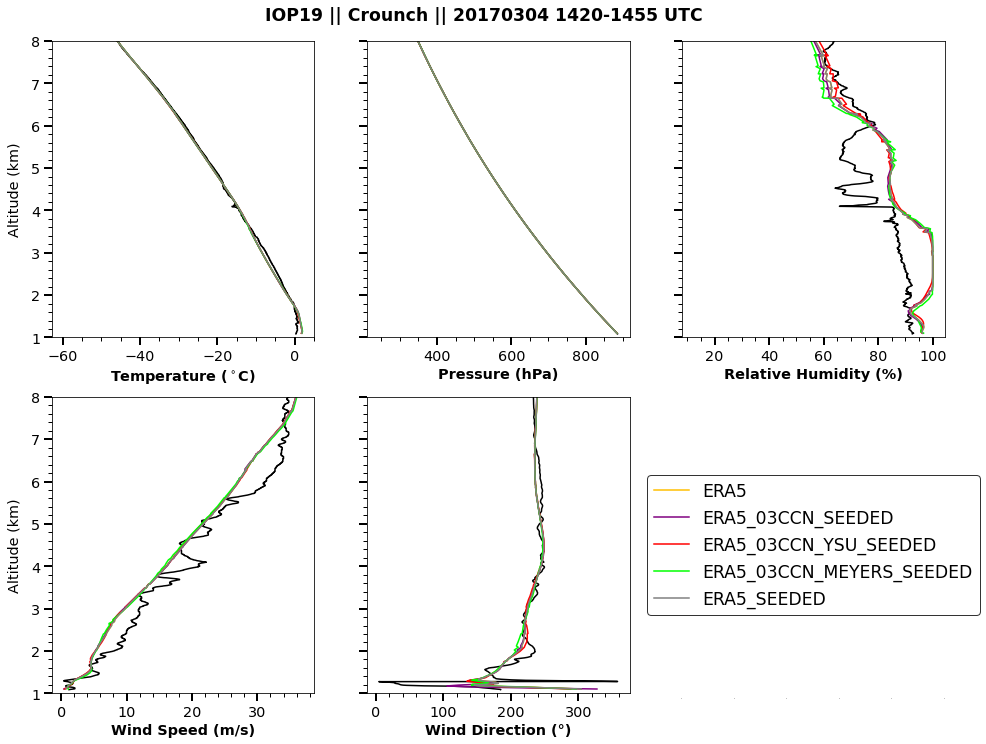

In [37]:
%%time
#************************
##-- Read Crounch sounding data during IOP19
#!!!

IOPS_crounch_file_path = "/glade/work/zhixing/Analysis_DATA/SNOWIE_observation/RADIOSONDE/Crounch_sounding/kcrh201703041401.txt"
IOPS_date  = '20170304 '
Crounch_Alt = '1082.6' ## The altitude of sounding site
IOPS_time_window = pd.date_range('20170304 142000', '20170304 145500', freq='5min') ## this time window depends on individual case  #!!!
SWITCH1 = 0 ## whether extract wrf data from wrfoutput file and then save into numpy array file 
SWITCH2 = 1 ## whether use the neighborhood approach
IOPS = 'IOP19'
VERSIONS = 'cr_'
TITLE = 'IOP19 || Crounch || 20170304 1420-1455 UTC'
# REANALYSIS_LIST =['ERA5_03CCN_MEYERS_SEEDED', 'ERA5_SEEDED']
# COLOR_LIST = ['purple','red']
# REANALYSIS_LIST = ['ERA5', 'ERAI', 'NARR', 'CFS2', 'ERA5_03CCN', 'ERA5_03CCN_MEYERS', 'ERA5_03CCN_YSU', 'ERA5_03CCN_SEEDED', 'ERA5_03CCN_YSU_SEEDED','ERA5_03CCN_MEYERS_SEEDED', 'ERA5_SEEDED']
# COLOR_LIST = ['#FFBF00','#FF7F50','#DE3163','#9FE2BF', '#40E0D0', '#6495ED', '#CCCCFF','purple', 'red', 'lightblue', 'lime']

# ht_X_900m_sounding_all_dic, rh_X_900m_sounding_all_dic, tem_X_900m_sounding_all_dic,\
# pre_X_900m_sounding_all_dic, wspd_X_900m_sounding_all_dic, wdir_X_900m_sounding_all_dic,\
# plot_s_tem_list, plot_s_pr_list, plot_s_rh_list, plot_s_ws_list, plot_s_wd_list, plot_s_ht_list \
# = integration_func(IOPS_Gauge_site_file_path=IOPS_crounch_file_path, IOPS_date=IOPS_date, Gauge_site_Alt=Crounch_Alt,\
#                    IOPS_time_window=IOPS_time_window, SWITCH1=SWITCH1, SWITCH2=SWITCH2, IOPS=IOPS, VERSIONS=VERSIONS,\
#                    TITLE=TITLE, reanalysis_list = REANALYSIS_LIST, color_list = COLOR_LIST)


plot_s_tem_list = np.load('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/cr_obs_s_tem_list.npy')
plot_s_pr_list  = np.load('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/cr_obs_s_pr_list.npy')
plot_s_rh_list  = np.load('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/cr_obs_s_rh_list.npy')
plot_s_ws_list  = np.load('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/cr_obs_s_ws_list.npy')
plot_s_wd_list  = np.load('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/cr_obs_s_wd_list.npy')
plot_s_ht_list  = np.load('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/cr_obs_s_ht_list.npy')


with open('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/cr_ht_X_900m_sounding_all_dic.pkl', 'rb') as f:
    ht_X_900m_sounding_all_dic = pickle.load(f)
    
with open('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/cr_rh_X_900m_sounding_all_dic.pkl', 'rb') as f:
    rh_X_900m_sounding_all_dic = pickle.load(f)
    
with open('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/cr_tem_X_900m_sounding_all_dic.pkl', 'rb') as f:
    tem_X_900m_sounding_all_dic = pickle.load(f)
    
with open('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/cr_pre_X_900m_sounding_all_dic.pkl', 'rb') as f:
    pre_X_900m_sounding_all_dic = pickle.load(f)
    
with open('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/cr_wspd_X_900m_sounding_all_dic.pkl', 'rb') as f:
    wspd_X_900m_sounding_all_dic = pickle.load(f)
    
with open('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/cr_wdir_X_900m_sounding_all_dic.pkl', 'rb') as f:
    wdir_X_900m_sounding_all_dic = pickle.load(f)
    
REANALYSIS_LIST = ['ERA5', 'ERAI', 'NARR', 'CFS2', 'ERA5_03CCN', 'ERA5_03CCN_MEYERS', 'ERA5_03CCN_YSU']
COLOR_LIST = ['#FFBF00','#FF7F50','#DE3163','#9FE2BF', '#40E0D0', '#6495ED', '#CCCCFF']

visulization(title=TITLE, plot_s_tem_list=plot_s_tem_list, plot_s_pr_list=plot_s_pr_list, plot_s_rh_list=plot_s_rh_list,\
             plot_s_ws_list=plot_s_ws_list, plot_s_wd_list=plot_s_wd_list, plot_s_ht_list=plot_s_ht_list,\
             ht_X_900m_sounding_all_dic=ht_X_900m_sounding_all_dic,rh_X_900m_sounding_all_dic=rh_X_900m_sounding_all_dic,\
             tem_X_900m_sounding_all_dic=tem_X_900m_sounding_all_dic,pre_X_900m_sounding_all_dic=pre_X_900m_sounding_all_dic,\
             wspd_X_900m_sounding_all_dic=wspd_X_900m_sounding_all_dic,wdir_X_900m_sounding_all_dic=wdir_X_900m_sounding_all_dic,\
             reanalysis_list = REANALYSIS_LIST, color_list = COLOR_LIST)

REANALYSIS_LIST = ['ERA5', 'ERA5_03CCN_SEEDED', 'ERA5_03CCN_YSU_SEEDED', 'ERA5_03CCN_MEYERS_SEEDED', 'ERA5_SEEDED']
COLOR_LIST = ['#FFBF00','purple', 'red', 'lime', 'gray']


visulization(title=TITLE, plot_s_tem_list=plot_s_tem_list, plot_s_pr_list=plot_s_pr_list, plot_s_rh_list=plot_s_rh_list,\
             plot_s_ws_list=plot_s_ws_list, plot_s_wd_list=plot_s_wd_list, plot_s_ht_list=plot_s_ht_list,\
             ht_X_900m_sounding_all_dic=ht_X_900m_sounding_all_dic,rh_X_900m_sounding_all_dic=rh_X_900m_sounding_all_dic,\
             tem_X_900m_sounding_all_dic=tem_X_900m_sounding_all_dic,pre_X_900m_sounding_all_dic=pre_X_900m_sounding_all_dic,\
             wspd_X_900m_sounding_all_dic=wspd_X_900m_sounding_all_dic,wdir_X_900m_sounding_all_dic=wdir_X_900m_sounding_all_dic,\
             reanalysis_list = REANALYSIS_LIST, color_list = COLOR_LIST)

In [13]:
# # ## So, this dictionary data contains the in-situ-wrf mathcing data in 4D (spatially and temporally) and used the neighboring approach

# with open('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/cr_ht_X_900m_sounding_all_dic.pkl', 'wb') as f:
#     pickle.dump(ht_X_900m_sounding_all_dic, f)
    
# with open('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/cr_rh_X_900m_sounding_all_dic.pkl', 'wb') as f:
#     pickle.dump(rh_X_900m_sounding_all_dic, f)
    
# with open('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/cr_tem_X_900m_sounding_all_dic.pkl', 'wb') as f:
#     pickle.dump(tem_X_900m_sounding_all_dic, f)
    
# with open('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/cr_pre_X_900m_sounding_all_dic.pkl', 'wb') as f:
#     pickle.dump(pre_X_900m_sounding_all_dic, f)

# with open('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/cr_wspd_X_900m_sounding_all_dic.pkl', 'wb') as f:
#     pickle.dump(wspd_X_900m_sounding_all_dic, f)

# with open('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/cr_wdir_X_900m_sounding_all_dic.pkl', 'wb') as f:
#     pickle.dump(wdir_X_900m_sounding_all_dic, f)

# # np.save('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/cr_obs_s_tem_list.npy',plot_s_tem_list)
# # np.save('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/cr_obs_s_pr_list.npy',plot_s_pr_list)
# # np.save('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/cr_obs_s_rh_list.npy',plot_s_rh_list)
# # np.save('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/cr_obs_s_ws_list.npy',plot_s_ws_list)
# # np.save('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/cr_obs_s_wd_list.npy',plot_s_wd_list)
# # np.save('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/cr_obs_s_ht_list.npy',plot_s_ht_list)


CPU times: user 261 ms, sys: 1.86 ms, total: 263 ms
Wall time: 360 ms


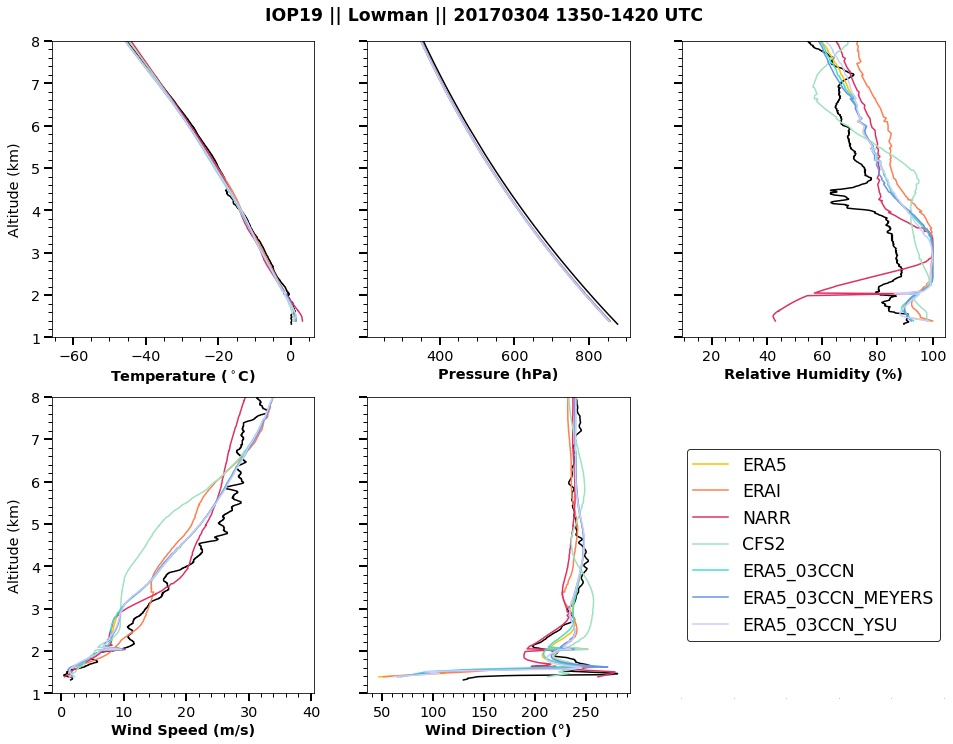

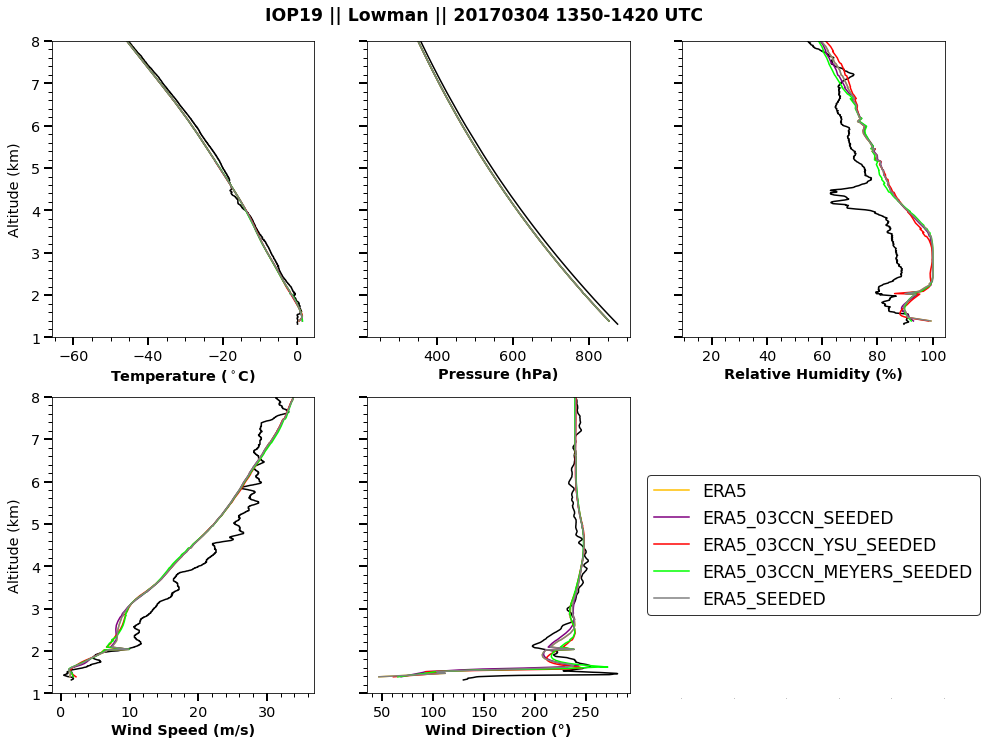

In [36]:
%%time
#************************
##-- Read Lowman sounding data during IOP19
#!!!
IOPS_lowman_file_path = "/glade/work/zhixing/Analysis_DATA/SNOWIE_observation/RADIOSONDE/Lowman_sounding/KLOW201703041401.txt"
IOPS_date  = '20170304 '
Lowman_Alt = '1315.0' ## The altitude of sounding site
IOPS_time_window = pd.date_range('20170304 135000', '20170304 142000', freq='5min') ## this time window depends on individual case  #!!!
SWITCH1 = 0 ## whether extract wrf data from wrfoutput file and then save into numpy array file 
SWITCH2 = 1 ## whether use the neighborhood approach
IOPS = 'IOP19'
VERSIONS = 'lw_'
TITLE = 'IOP19 || Lowman || 20170304 1350-1420 UTC'

# REANALYSIS_LIST =['ERA5_03CCN_YSU_SEEDED']
# COLOR_LIST = ['purple']
# REANALYSIS_LIST = ['ERA5', 'ERAI', 'NARR', 'CFS2', 'ERA5_03CCN', 'ERA5_03CCN_MEYERS', 'ERA5_03CCN_YSU', 'ERA5_03CCN_SEEDED', 'ERA5_03CCN_YSU_SEEDED','ERA5_03CCN_MEYERS_SEEDED', 'ERA5_SEEDED']
# COLOR_LIST = ['#FFBF00','#FF7F50','#DE3163','#9FE2BF', '#40E0D0', '#6495ED', '#CCCCFF','purple', 'red', 'lightblue', 'lime']

# ht_X_900m_sounding_all_dic, rh_X_900m_sounding_all_dic, tem_X_900m_sounding_all_dic,\
# pre_X_900m_sounding_all_dic, wspd_X_900m_sounding_all_dic, wdir_X_900m_sounding_all_dic,\
# plot_s_tem_list, plot_s_pr_list, plot_s_rh_list, plot_s_ws_list, plot_s_wd_list, plot_s_ht_list \
# = integration_func(IOPS_Gauge_site_file_path=IOPS_lowman_file_path, IOPS_date=IOPS_date, Gauge_site_Alt=Lowman_Alt,\
#                    IOPS_time_window=IOPS_time_window, SWITCH1=SWITCH1, SWITCH2=SWITCH2, IOPS=IOPS, VERSIONS=VERSIONS,\
#                    TITLE=TITLE, reanalysis_list = REANALYSIS_LIST, color_list = COLOR_LIST)


plot_s_tem_list = np.load('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p1_lw_obs_s_tem_list.npy')
plot_s_pr_list  = np.load('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p1_lw_obs_s_pr_list.npy')
plot_s_rh_list  = np.load('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p1_lw_obs_s_rh_list.npy')
plot_s_ws_list  = np.load('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p1_lw_obs_s_ws_list.npy')
plot_s_wd_list  = np.load('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p1_lw_obs_s_wd_list.npy')
plot_s_ht_list  = np.load('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p1_lw_obs_s_ht_list.npy')


with open('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p1_lw_ht_X_900m_sounding_all_dic.pkl', 'rb') as f:
    ht_X_900m_sounding_all_dic = pickle.load(f)
    
with open('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p1_lw_rh_X_900m_sounding_all_dic.pkl', 'rb') as f:
    rh_X_900m_sounding_all_dic = pickle.load(f)
    
with open('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p1_lw_tem_X_900m_sounding_all_dic.pkl', 'rb') as f:
    tem_X_900m_sounding_all_dic = pickle.load(f)
    
with open('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p1_lw_pre_X_900m_sounding_all_dic.pkl', 'rb') as f:
    pre_X_900m_sounding_all_dic = pickle.load(f)
    
with open('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p1_lw_wspd_X_900m_sounding_all_dic.pkl', 'rb') as f:
    wspd_X_900m_sounding_all_dic = pickle.load(f)
    
with open('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p1_lw_wdir_X_900m_sounding_all_dic.pkl', 'rb') as f:
    wdir_X_900m_sounding_all_dic = pickle.load(f)
    
    
REANALYSIS_LIST = ['ERA5', 'ERAI', 'NARR', 'CFS2', 'ERA5_03CCN', 'ERA5_03CCN_MEYERS', 'ERA5_03CCN_YSU']
COLOR_LIST = ['#FFBF00','#FF7F50','#DE3163','#9FE2BF', '#40E0D0', '#6495ED', '#CCCCFF']

visulization(title=TITLE, plot_s_tem_list=plot_s_tem_list, plot_s_pr_list=plot_s_pr_list, plot_s_rh_list=plot_s_rh_list,\
             plot_s_ws_list=plot_s_ws_list, plot_s_wd_list=plot_s_wd_list, plot_s_ht_list=plot_s_ht_list,\
             ht_X_900m_sounding_all_dic=ht_X_900m_sounding_all_dic,rh_X_900m_sounding_all_dic=rh_X_900m_sounding_all_dic,\
             tem_X_900m_sounding_all_dic=tem_X_900m_sounding_all_dic,pre_X_900m_sounding_all_dic=pre_X_900m_sounding_all_dic,\
             wspd_X_900m_sounding_all_dic=wspd_X_900m_sounding_all_dic,wdir_X_900m_sounding_all_dic=wdir_X_900m_sounding_all_dic,\
             reanalysis_list = REANALYSIS_LIST, color_list = COLOR_LIST)

REANALYSIS_LIST = ['ERA5', 'ERA5_03CCN_SEEDED', 'ERA5_03CCN_YSU_SEEDED', 'ERA5_03CCN_MEYERS_SEEDED', 'ERA5_SEEDED']
COLOR_LIST = ['#FFBF00','purple', 'red', 'lime', 'gray']


visulization(title=TITLE, plot_s_tem_list=plot_s_tem_list, plot_s_pr_list=plot_s_pr_list, plot_s_rh_list=plot_s_rh_list,\
             plot_s_ws_list=plot_s_ws_list, plot_s_wd_list=plot_s_wd_list, plot_s_ht_list=plot_s_ht_list,\
             ht_X_900m_sounding_all_dic=ht_X_900m_sounding_all_dic,rh_X_900m_sounding_all_dic=rh_X_900m_sounding_all_dic,\
             tem_X_900m_sounding_all_dic=tem_X_900m_sounding_all_dic,pre_X_900m_sounding_all_dic=pre_X_900m_sounding_all_dic,\
             wspd_X_900m_sounding_all_dic=wspd_X_900m_sounding_all_dic,wdir_X_900m_sounding_all_dic=wdir_X_900m_sounding_all_dic,\
             reanalysis_list = REANALYSIS_LIST, color_list = COLOR_LIST)

In [15]:
# # ## So, this dictionary data contains the in-situ-wrf mathcing data in 4D (spatially and temporally) and used the neighboring approach

# with open('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p1_lw_ht_X_900m_sounding_all_dic.pkl', 'wb') as f:
#     pickle.dump(ht_X_900m_sounding_all_dic, f)
    
# with open('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p1_lw_rh_X_900m_sounding_all_dic.pkl', 'wb') as f:
#     pickle.dump(rh_X_900m_sounding_all_dic, f)
    
# with open('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p1_lw_tem_X_900m_sounding_all_dic.pkl', 'wb') as f:
#     pickle.dump(tem_X_900m_sounding_all_dic, f)
    
# with open('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p1_lw_pre_X_900m_sounding_all_dic.pkl', 'wb') as f:
#     pickle.dump(pre_X_900m_sounding_all_dic, f)

# with open('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p1_lw_wspd_X_900m_sounding_all_dic.pkl', 'wb') as f:
#     pickle.dump(wspd_X_900m_sounding_all_dic, f)

# with open('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p1_lw_wdir_X_900m_sounding_all_dic.pkl', 'wb') as f:
#     pickle.dump(wdir_X_900m_sounding_all_dic, f)

# # np.save('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p1_lw_obs_s_tem_list.npy',plot_s_tem_list)
# # np.save('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p1_lw_obs_s_pr_list.npy',plot_s_pr_list)
# # np.save('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p1_lw_obs_s_rh_list.npy',plot_s_rh_list)
# # np.save('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p1_lw_obs_s_ws_list.npy',plot_s_ws_list)
# # np.save('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p1_lw_obs_s_wd_list.npy',plot_s_wd_list)
# # np.save('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p1_lw_obs_s_ht_list.npy',plot_s_ht_list)


CPU times: user 263 ms, sys: 1.33 ms, total: 264 ms
Wall time: 280 ms


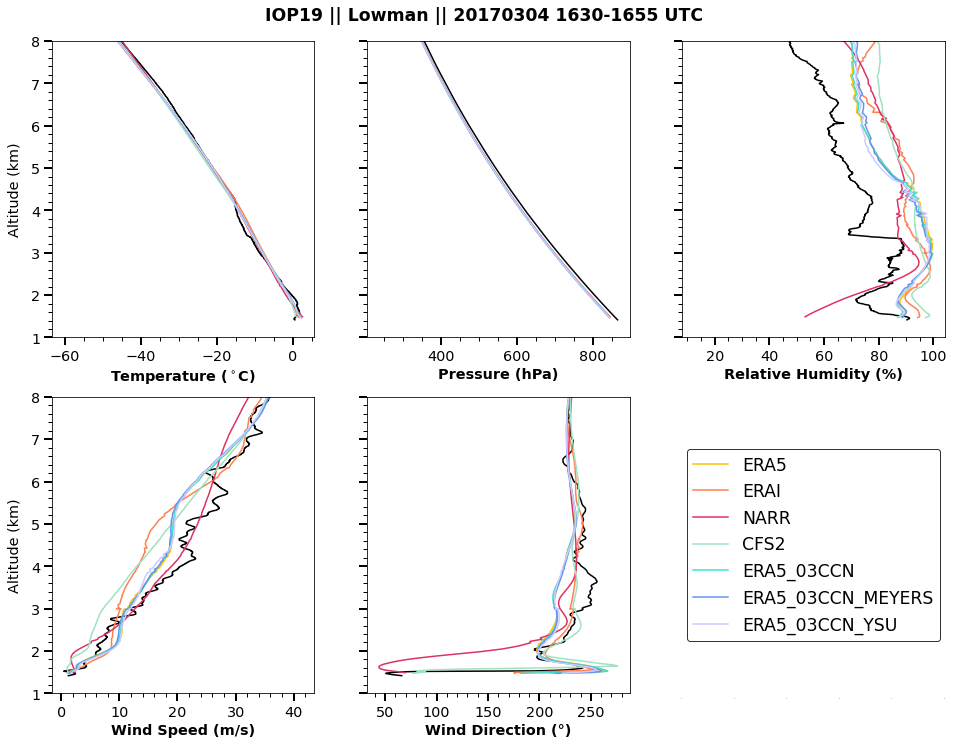

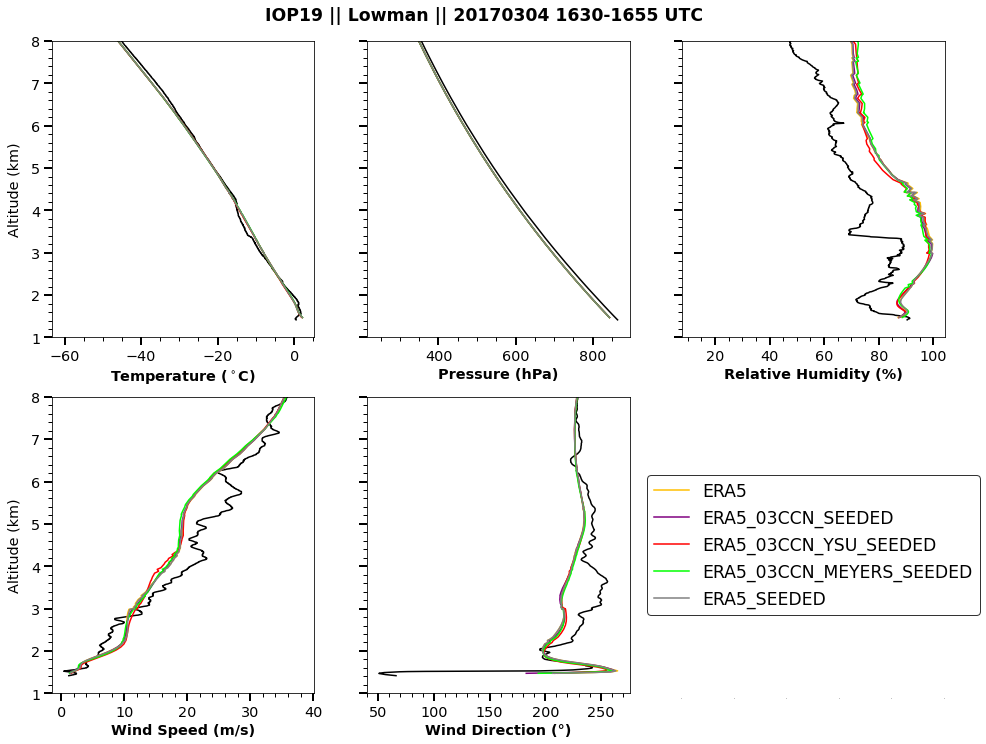

In [35]:
%%time
#************************
##-- Read Lowman sounding data during IOP19
#!!!
IOPS_lowman_file_path = "/glade/work/zhixing/Analysis_DATA/SNOWIE_observation/RADIOSONDE/Lowman_sounding/KLOW201703041601.txt"
IOPS_date  = '20170304 '
Lowman_Alt = '1315.0' ## The altitude of sounding site
IOPS_time_window = pd.date_range('20170304 163000', '20170304 165500', freq='5min') ## this time window depends on individual case  #!!!
SWITCH1 = 0 ## whether extract wrf data from wrfoutput file and then save into numpy array file 
SWITCH2 = 1 ## whether use the neighborhood approach
IOPS = 'IOP19'
VERSIONS = 'v2_lw_'
TITLE = 'IOP19 || Lowman || 20170304 1630-1655 UTC'

# REANALYSIS_LIST =['ERA5_03CCN_YSU_SEEDED', 'ERA5_03CCN_MEYERS_SEEDED', 'ERA5_SEEDED']
# COLOR_LIST = ['purple','red', 'lime']
REANALYSIS_LIST = ['ERA5', 'ERAI', 'NARR', 'CFS2', 'ERA5_03CCN', 'ERA5_03CCN_MEYERS', 'ERA5_03CCN_YSU', 'ERA5_03CCN_SEEDED', 'ERA5_03CCN_YSU_SEEDED', 'ERA5_03CCN_MEYERS_SEEDED', 'ERA5_SEEDED']
COLOR_LIST = ['#FFBF00','#FF7F50','#DE3163','#9FE2BF', '#40E0D0', '#6495ED', '#CCCCFF','purple', 'red', 'lime', 'gray']

# ht_X_900m_sounding_all_dic, rh_X_900m_sounding_all_dic, tem_X_900m_sounding_all_dic,\
# pre_X_900m_sounding_all_dic, wspd_X_900m_sounding_all_dic, wdir_X_900m_sounding_all_dic,\
# plot_s_tem_list, plot_s_pr_list, plot_s_rh_list, plot_s_ws_list, plot_s_wd_list, plot_s_ht_list \
# = integration_func(IOPS_Gauge_site_file_path=IOPS_lowman_file_path, IOPS_date=IOPS_date, Gauge_site_Alt=Lowman_Alt,\
#                    IOPS_time_window=IOPS_time_window, SWITCH1=SWITCH1, SWITCH2=SWITCH2, IOPS=IOPS, VERSIONS=VERSIONS,\
#                    TITLE=TITLE, reanalysis_list = REANALYSIS_LIST, color_list = COLOR_LIST)


# plot_s_tem_list = np.load('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p2_lw_obs_s_tem_list.npy')
# plot_s_pr_list  = np.load('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p2_lw_obs_s_pr_list.npy')
# plot_s_rh_list  = np.load('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p2_lw_obs_s_rh_list.npy')
# plot_s_ws_list  = np.load('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p2_lw_obs_s_ws_list.npy')
# plot_s_wd_list  = np.load('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p2_lw_obs_s_wd_list.npy')
# plot_s_ht_list  = np.load('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p2_lw_obs_s_ht_list.npy')


with open('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p2_lw_ht_X_900m_sounding_all_dic.pkl', 'rb') as f:
    ht_X_900m_sounding_all_dic = pickle.load(f)
    
with open('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p2_lw_rh_X_900m_sounding_all_dic.pkl', 'rb') as f:
    rh_X_900m_sounding_all_dic = pickle.load(f)
    
with open('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p2_lw_tem_X_900m_sounding_all_dic.pkl', 'rb') as f:
    tem_X_900m_sounding_all_dic = pickle.load(f)
    
with open('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p2_lw_pre_X_900m_sounding_all_dic.pkl', 'rb') as f:
    pre_X_900m_sounding_all_dic = pickle.load(f)
    
with open('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p2_lw_wspd_X_900m_sounding_all_dic.pkl', 'rb') as f:
    wspd_X_900m_sounding_all_dic = pickle.load(f)
    
with open('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p2_lw_wdir_X_900m_sounding_all_dic.pkl', 'rb') as f:
    wdir_X_900m_sounding_all_dic = pickle.load(f)

    
REANALYSIS_LIST = ['ERA5', 'ERAI', 'NARR', 'CFS2', 'ERA5_03CCN', 'ERA5_03CCN_MEYERS', 'ERA5_03CCN_YSU']
COLOR_LIST = ['#FFBF00','#FF7F50','#DE3163','#9FE2BF', '#40E0D0', '#6495ED', '#CCCCFF']

visulization(title=TITLE, plot_s_tem_list=plot_s_tem_list, plot_s_pr_list=plot_s_pr_list, plot_s_rh_list=plot_s_rh_list,\
             plot_s_ws_list=plot_s_ws_list, plot_s_wd_list=plot_s_wd_list, plot_s_ht_list=plot_s_ht_list,\
             ht_X_900m_sounding_all_dic=ht_X_900m_sounding_all_dic,rh_X_900m_sounding_all_dic=rh_X_900m_sounding_all_dic,\
             tem_X_900m_sounding_all_dic=tem_X_900m_sounding_all_dic,pre_X_900m_sounding_all_dic=pre_X_900m_sounding_all_dic,\
             wspd_X_900m_sounding_all_dic=wspd_X_900m_sounding_all_dic,wdir_X_900m_sounding_all_dic=wdir_X_900m_sounding_all_dic,\
             reanalysis_list = REANALYSIS_LIST, color_list = COLOR_LIST)

REANALYSIS_LIST = ['ERA5', 'ERA5_03CCN_SEEDED', 'ERA5_03CCN_YSU_SEEDED', 'ERA5_03CCN_MEYERS_SEEDED', 'ERA5_SEEDED']
COLOR_LIST = ['#FFBF00','purple', 'red', 'lime', 'gray']


visulization(title=TITLE, plot_s_tem_list=plot_s_tem_list, plot_s_pr_list=plot_s_pr_list, plot_s_rh_list=plot_s_rh_list,\
             plot_s_ws_list=plot_s_ws_list, plot_s_wd_list=plot_s_wd_list, plot_s_ht_list=plot_s_ht_list,\
             ht_X_900m_sounding_all_dic=ht_X_900m_sounding_all_dic,rh_X_900m_sounding_all_dic=rh_X_900m_sounding_all_dic,\
             tem_X_900m_sounding_all_dic=tem_X_900m_sounding_all_dic,pre_X_900m_sounding_all_dic=pre_X_900m_sounding_all_dic,\
             wspd_X_900m_sounding_all_dic=wspd_X_900m_sounding_all_dic,wdir_X_900m_sounding_all_dic=wdir_X_900m_sounding_all_dic,\
             reanalysis_list = REANALYSIS_LIST, color_list = COLOR_LIST)

In [26]:
# ## So, this dictionary data contains the in-situ-wrf mathcing data in 4D (spatially and temporally) and used the neighboring approach

# with open('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p2_lw_ht_X_900m_sounding_all_dic.pkl', 'wb') as f:
#     pickle.dump(ht_X_900m_sounding_all_dic, f)
    
# with open('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p2_lw_rh_X_900m_sounding_all_dic.pkl', 'wb') as f:
#     pickle.dump(rh_X_900m_sounding_all_dic, f)
    
# with open('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p2_lw_tem_X_900m_sounding_all_dic.pkl', 'wb') as f:
#     pickle.dump(tem_X_900m_sounding_all_dic, f)
    
# with open('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p2_lw_pre_X_900m_sounding_all_dic.pkl', 'wb') as f:
#     pickle.dump(pre_X_900m_sounding_all_dic, f)

# with open('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p2_lw_wspd_X_900m_sounding_all_dic.pkl', 'wb') as f:
#     pickle.dump(wspd_X_900m_sounding_all_dic, f)

# with open('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p2_lw_wdir_X_900m_sounding_all_dic.pkl', 'wb') as f:
#     pickle.dump(wdir_X_900m_sounding_all_dic, f)

# np.save('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p2_lw_obs_s_tem_list.npy',plot_s_tem_list)
# np.save('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p2_lw_obs_s_pr_list.npy',plot_s_pr_list)
# np.save('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p2_lw_obs_s_rh_list.npy',plot_s_rh_list)
# np.save('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p2_lw_obs_s_ws_list.npy',plot_s_ws_list)
# np.save('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p2_lw_obs_s_wd_list.npy',plot_s_wd_list)
# np.save('/glade/scratch/zhixing/CTRL_Simulations/IOP19/For_Sounding_Valid/For_Plot_Processed_Data/p2_lw_obs_s_ht_list.npy',plot_s_ht_list)
